In [57]:
import pandas as pd
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [58]:
test_data=pd.DataFrame(pd.read_csv("./mnist_test.csv"))
train_data=pd.DataFrame(pd.read_csv("./mnist_train.csv"))
# check=torch.tensor(np.array(train_data.iloc[:1,1:]))
# print(((train_data.iloc[:1,1:]).shape))
# plt.imshow(check.reshape((28,28)))
X=train_data.iloc[:,1:].values/255

X=(X-0.5)/0.5 ## Normalization

Y=train_data.iloc[:,0]

# print(Y.shape)
# print(X.shape)

In [59]:
train_x,val_x,train_y,val_y=train_test_split(X,Y,test_size=0.2)
X_train_tensor = torch.tensor(train_x, dtype=torch.float32)
y_train_tensor = torch.tensor(train_y, dtype=torch.long)
X_val_tensor = torch.tensor(np.array(val_x), dtype=torch.float32)
y_val_tensor = torch.tensor(np.array(val_y), dtype=torch.long)


train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
val_dataset=TensorDataset(X_val_tensor,y_val_tensor)
batch_size=64
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(val_dataset,64,shuffle=False)



In [60]:
def add_noise(images,sigma):
    noise=torch.randn_like(images)*sigma
    noisy_images=images+noise
    return torch.clamp(noisy_images,0,1)

In [61]:
def calculate_average_ssim(model, test_loader, sigma):
    model.eval()
    total_ssim = 0.0
    for images, _ in test_loader:
        noisy_images = add_noise(images, sigma)
        reconstructed_images = model(noisy_images)
        for i in range(len(images)):
            total_ssim += ssim(images[i].squeeze().numpy(), reconstructed_images[i].squeeze().detach().numpy(),data_range=2)
    return total_ssim / len(test_loader.dataset)

In [62]:
print(len(X_train_tensor[10]))

784


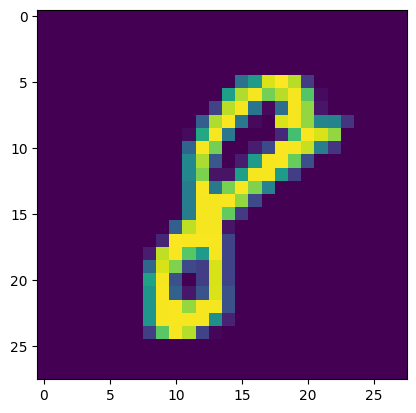

In [63]:
# plt.im(X_train_tensor[0])
plt.imshow(X_train_tensor[0].reshape((28,28)))
plt.imshow(X_train_tensor[0].reshape((28,28)))

In [64]:
# 
class AE1(torch.nn.Module):
	def __init__(self,bottleneck_layer=18):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.bottleneck_layer=bottleneck_layer
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 256),
			torch.nn.ReLU(),
			torch.nn.Linear(256, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, bottleneck_layer),
			
		)
		
	
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(bottleneck_layer, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128,256),
			torch.nn.ReLU(),
			torch.nn.Linear(256, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded



In [65]:
AE1_model=AE1()
loss_func=nn.MSELoss()
optimizer=torch.torch.optim.Adam(AE1_model.parameters(),lr=0.0001)
print(AE1_model)

AE1(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [66]:


# Train and evaluate model with varying sigma values
sigmas = [0.1, 0.3, 0.5]
# bottleneck_dim = 16
for sigma in sigmas:
    num_epochs = 5
    for epoch in range(num_epochs):
        # AE1_model.train()
        for images, _ in train_loader:
            noisy_images = add_noise(images, sigma)
            optimizer.zero_grad()
            reconstructed_images = AE1_model(noisy_images)
            loss = loss_func(reconstructed_images, images)
            loss.backward()
            optimizer.step()

    average_ssim = calculate_average_ssim(AE1_model, test_loader, sigma)
    print(f'Sigma: {sigma}, Average SSIM: {average_ssim:.4f}')

print("\n")

# Change bottleneck dimensionality and evaluate SSIM
bottleneck_dims = [12, 20, 28]
sigma = 0.1
for bottleneck_dim in bottleneck_dims:
    model = AE1(bottleneck_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for images, _ in train_loader:
            noisy_images = add_noise(images, sigma)
            optimizer.zero_grad()
            reconstructed_images = model(noisy_images)
            loss = criterion(reconstructed_images, images)
            loss.backward()
            optimizer.step()

    average_ssim = calculate_average_ssim(model, test_loader, sigma)
    print(f'Bottleneck Dimension: {bottleneck_dim}, Average SSIM: {average_ssim:.4f}')

Sigma: 0.1, Average SSIM: 0.0003
Sigma: 0.3, Average SSIM: 0.0003
Sigma: 0.5, Average SSIM: 0.0002


Bottleneck Dimension: 12, Average SSIM: 0.0003
Bottleneck Dimension: 20, Average SSIM: 0.0003
Bottleneck Dimension: 28, Average SSIM: 0.0003


In [ ]:
##2nd encoder decoder architecture


In [67]:
import torch
import torch.nn as nn

class AE2(nn.Module):
    def __init__(self, latent_dim):
        super(AE2, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

        # Fully connected layer to map bottleneck to desired dimension
        self.fc = nn.Linear(32 * 7 * 7, self.latent_dim)

        # Fully connected layer to map bottleneck back to original dimension
        self.fc_reverse = nn.Linear(self.latent_dim, 32 * 7 * 7)

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = x.view(-1, 32 * 7 * 7)  # Flatten for fully connected layer
        x = self.fc(x)  # Map to bottleneck dimension

        # Decoder
        x = self.fc_reverse(x)
        x = x.view(-1, 32, 7, 7)  # Reshape for convolutional layers
        x = self.decoder(x)
        return x


In [136]:
AE2_model=AE2(100)
loss_func=nn.MSELoss()
optimizer=torch.torch.optim.Adam(AE2_model.parameters(),lr=0.0001)
print(AE2_model)

AE2(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (fc): Linear(in_features=1568, out_features=100, bias=True)
  (fc_reverse): Linear(in_features=100, out_features=1568, bias=True)
)


In [71]:


# Train and evaluate model with varying sigma values
sigmas = [0.1, 0.3, 0.5]
bottleneck_dim = 16
for sigma in sigmas:
    model =AE2(bottleneck_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for images, _ in train_loader:
            noisy_images = add_noise(images, sigma)
            optimizer.zero_grad()
            reconstructed_images = model(noisy_images)
            loss = criterion(reconstructed_images, images)
            loss.backward()
            optimizer.step()

    average_ssim = calculate_average_ssim(model, test_loader, sigma)
    print(f'Sigma: {sigma}, Average SSIM: {average_ssim:.4f}')

# Change bottleneck dimensionality and evaluate SSIM
bottleneck_dims = [8, 16, 32]
sigma = 0.3
for bottleneck_dim in bottleneck_dims:
    model = AE2(bottleneck_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for images, _ in train_loader:
            noisy_images = add_noise(images, sigma)
            optimizer.zero_grad()
            reconstructed_images = model(noisy_images)
            loss = criterion(reconstructed_images, images)
            loss.backward()
            optimizer.step()

    average_ssim = calculate_average_ssim(model, test_loader, sigma)
    print(f'Bottleneck Dimension: {bottleneck_dim}, Average SSIM: {average_ssim:.4f}')


Sigma: 0.1, Average SSIM: 0.8706
Sigma: 0.3, Average SSIM: 0.8448
Sigma: 0.5, Average SSIM: 0.8103
Bottleneck Dimension: 8, Average SSIM: 0.7392
Bottleneck Dimension: 16, Average SSIM: 0.8516
Bottleneck Dimension: 32, Average SSIM: 0.9070


Analysis:
1. Impact of Gaussian Noise with Varying Sigma Values:
Observation:
As the sigma value increases (0.1 to 0.5), the average SSIM test score decreases.
Higher sigma values indicate higher levels of noise, which can degrade image quality and impact reconstruction performance.
Explanation:
Higher sigma values lead to more intense noise, making it harder for the model to reconstruct the original image accurately.
The decrease in SSIM score indicates reduced similarity between the original and reconstructed images as noise level increases.
2. Impact of Bottleneck Dimensionality:
Observation:
Increasing the bottleneck dimensionality from 8 to 16 to 32 results in an increase in the average SSIM test score.
Explanation:
A higher bottleneck dimensionality allows the model to capture more information during encoding, facilitating better reconstruction during decoding.
With a higher bottleneck dimensionality, the model has more capacity to preserve important features of the input image, resulting in improved reconstruction quality.
The increase in SSIM score indicates higher similarity between the original and reconstructed images with a larger bottleneck dimensionality.
